In [13]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

mpl.rcParams['figure.figsize'] = (10, 8)
mpl.rcParams['axes.grid'] = False

In [4]:
# creating a dataframe from the csv file
df = pd.DataFrame(pd.read_csv('./CSI_Preprocessing/output/zero4_outputs.csv'))
df = df.drop([df.columns[0]], axis='columns') 
df = df.iloc[:,:-3]
df.reset_index(drop=True, inplace=True)
  
# unit='s' to convert it into epoch time
df['Time'] = pd.to_datetime(df['Time'])
  
date_time = df['Time'].dt.strftime('%S')


# checking our dataframe once again
df.head()

,Time,Subcar_0,Subcar_1,Subcar_2,Subcar_3,Subcar_4,Subcar_5,Subcar_6,Subcar_7,Subcar_8,...,Subcar_52,Subcar_53,Subcar_54,Subcar_55,Subcar_56,Subcar_57,Subcar_58,Subcar_59,Subcar_60,Subcar_61
0,1970-01-01 00:00:01.641598541,5499.938181,7461.867126,6230.129694,8741.921642,297.127919,327.200244,362.527240,353.411941,351.432782,...,437.649403,412.093436,393.782935,396.807258,398.600050,399.450873,405.544079,402.951610,372.625818,343.914233
1,1970-01-01 00:00:01.641598542,5499.938181,7461.867126,6230.129694,8741.921642,350.910245,340.565706,338.013313,332.434956,327.232333,...,367.766230,339.484904,339.087009,343.083080,343.739727,346.943799,351.039884,350.000000,353.509547,361.763735
2,1970-01-01 00:00:01.641598543,5499.938181,7461.867126,6230.129694,8741.921642,357.572370,389.307077,421.911128,424.001179,447.754397,...,466.309983,418.119600,397.935924,387.985824,371.260017,354.983098,338.710791,315.483756,278.195974,245.790561
3,1970-01-01 00:00:01.641598544,5499.938181,7461.867126,6230.129694,8741.921642,507.385455,518.653063,533.348854,545.424605,542.492396,...,459.243944,413.706418,406.503383,392.998728,389.802514,381.072172,390.508643,384.002604,387.497097,393.782935
4,1970-01-01 00:00:01.641598545,5499.938181,7461.867126,6230.129694,8741.921642,379.117396,397.553770,415.226444,450.480854,445.583887,...,653.314626,626.906692,633.941638,639.366092,651.254942,668.481862,671.060355,670.391677,646.208945,616.507096


In [5]:
df.loc[0, 'Time']

Timestamp('1970-01-01 00:00:01.641598541')

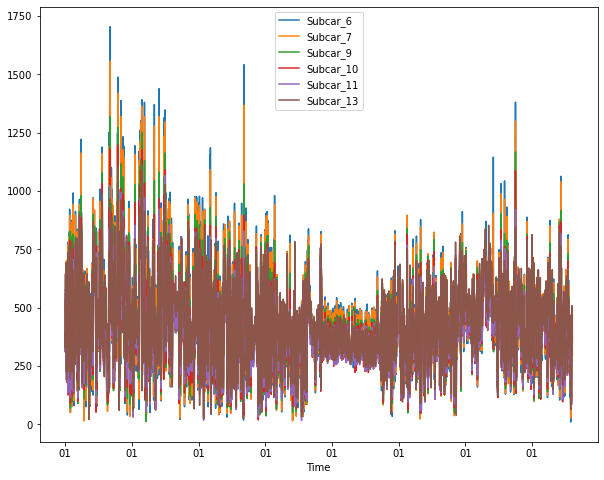

In [6]:
plot_cols = ['Subcar_6', 'Subcar_7','Subcar_9','Subcar_10', 'Subcar_11', 'Subcar_13']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=False)

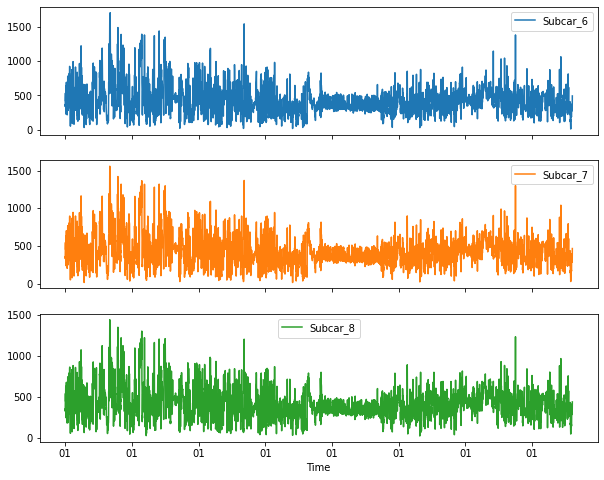

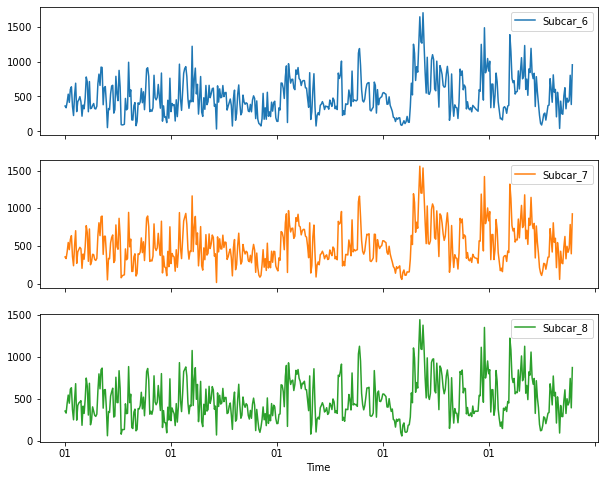

In [7]:
plot_cols = ['Subcar_6', 'Subcar_7', 'Subcar_8']
plot_features = df[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = df[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [8]:
# Set the date column as the index of your DataFrame meat
df = df.set_index('Time')

# Print the summary statistics of the DataFrame
print(df.describe())

          Subcar_0     Subcar_1     Subcar_2     Subcar_3     Subcar_4  \
count  3802.000000  3802.000000  3802.000000  3802.000000  3802.000000   
mean   5482.579092  7455.158794  6233.369403  8730.690589   437.319876   
std     308.541115   114.541341    63.095344   167.604655   494.960094   
min       0.000000  5499.938181  6230.129694  6230.129694     6.000000   
25%    5499.938181  7461.867126  6230.129694  8741.921642   277.672016   
50%    5499.938181  7461.867126  6230.129694  8741.921642   379.214319   
75%    5499.938181  7461.867126  6230.129694  8741.921642   502.360386   
max    5499.938181  7461.867126  7461.867126  8741.921642  8741.921642   

          Subcar_5     Subcar_6     Subcar_7     Subcar_8     Subcar_9  ...  \
count  3802.000000  3802.000000  3802.000000  3802.000000  3802.000000  ...   
mean    418.955691   422.932055   422.431979   413.767333   410.627681  ...   
std     208.937454   202.453002   193.543158   181.690717   171.775869  ...   
min       4.24264

In [31]:
# Adding headers
data_1 = pd.read_csv('./CSI_Preprocessing/output/train_data.csv', encoding='utf-8', header=None)
data_1 = data_1.drop([df.columns[0]], axis='columns')  # remove index column
data_1 = data_1.drop(0, axis='rows')  # remove column name (first row)
data_1.reset_index(drop=True, inplace=True)
data_1.columns -= 1
data_1.columns = ['Time', 'Subcar_0','Subcar_1', 'Subcar_2', 'Subcar_3', 'Subcar_4', 'Subcar_5', 'Subcar_6',
            'Subcar_7', 'Subcar_8', 'Subcar_9', 'Subcar_10', 'Subcar_11', 'Subcar_12',
            'Subcar_13', 'Subcar_14', 'Subcar_15', 'Subcar_16', 'Subcar_17', 'Subcar_18',
            'Subcar_19', 'Subcar_20', 'Subcar_21', 'Subcar_22', 'Subcar_23', 'Subcar_24',
            'Subcar_25', 'Subcar_26', 'Subcar_27', 'Subcar_28', 'Subcar_29', 'Subcar_30',
            'Subcar_31', 'Subcar_32', 'Subcar_33', 'Subcar_34', 'Subcar_35', 'Subcar_36'
            'Subcar_37', 'Subcar_38', 'Subcar_39', 'Subcar_40', 'Subcar_41', 'Subcar_42',
            'Subcar_43', 'Subcar_44', 'Subcar_45', 'Subcar_46', 'Subcar_47', 'Subcar_48',
            'Subcar_49', 'Subcar_50', 'Subcar_51', 'Subcar_52', 'Subcar_53', 'Subcar_54',
            'Subcar_55', 'Subcar_56', 'Subcar_57', 'Subcar_58', 'Subcar_59', 'Subcar_60',
            'Subcar_61', 'Subcar_62', 'Subcar_63','Subcar_64', 'Label']
data_1.head()

,Time,Subcar_0,Subcar_1,Subcar_2,Subcar_3,Subcar_4,Subcar_5,Subcar_6,Subcar_7,Subcar_8,...,Subcar_56,Subcar_57,Subcar_58,Subcar_59,Subcar_60,Subcar_61,Subcar_62,Subcar_63,Subcar_64,Label
0,1.625554e+09,4343.04985,11583.116204,6556.174571,9442.766173,866.199169,887.929051,905.756038,904.191351,895.897874,...,193.258894,175.889170,183.521116,182.912547,239.676866,312.078516,0.0,2146.567725,4778.184592,-1
1,1.625554e+09,4343.04985,11583.116204,6556.174571,9442.766173,840.401095,859.684826,886.599120,888.981440,879.275270,...,205.805734,178.809955,191.083751,169.543505,230.412673,296.319085,0.0,2146.567725,4778.184592,-1
2,1.625554e+09,4343.04985,11583.116204,6556.174571,9442.766173,830.003614,846.435467,868.256299,857.184344,845.568448,...,167.868997,162.003086,211.981131,199.251098,175.635987,157.848028,0.0,2146.567725,4778.184592,-1
3,1.625554e+09,4343.04985,11583.116204,6556.174571,9442.766173,799.115761,837.195915,884.864961,890.982042,900.568709,...,249.064249,227.369743,131.552271,113.137085,92.070625,85.000000,0.0,2146.567725,4778.184592,-1
4,1.625554e+09,4343.04985,11583.116204,6556.174571,9442.766173,864.070020,884.672256,910.140648,897.427434,899.608804,...,179.044687,159.765453,195.473783,181.796590,174.977141,179.426865,0.0,2146.567725,4778.184592,-1


In [50]:
  
# creating a dataframe from the csv file
data_2 = pd.DataFrame(pd.read_csv('./CSI_Preprocessing/output/train_outputs.csv'))
data_2 = data_2.drop([data_2.columns[0]], axis='columns') 
data_2.drop('Subcar_62', axis=1, inplace=True)
data_2.reset_index(drop=True, inplace=True)

# unit='s' to convert it into epoch time
data_2['Time'] = pd.to_datetime(data_2['Time'])
  
date_time = data_2['Time'].dt.strftime('%S')


# checking our dataframe once again
data_2.head()

,Time,Subcar_0,Subcar_1,Subcar_2,Subcar_3,Subcar_4,Subcar_5,Subcar_6,Subcar_7,Subcar_8,...,Subcar_55,Subcar_56,Subcar_57,Subcar_58,Subcar_59,Subcar_60,Subcar_61,Subcar_63,Subcar_64,Label
0,1970-01-01 00:00:01.625554196,4343.04985,11583.116204,6556.174571,9442.766173,866.199169,887.929051,905.756038,904.191351,895.897874,...,223.647043,193.258894,175.889170,183.521116,182.912547,239.676866,312.078516,2146.567725,4778.184592,-1
1,1970-01-01 00:00:01.625554196,4343.04985,11583.116204,6556.174571,9442.766173,840.401095,859.684826,886.599120,888.981440,879.275270,...,228.116198,205.805734,178.809955,191.083751,169.543505,230.412673,296.319085,2146.567725,4778.184592,-1
2,1970-01-01 00:00:01.625554196,4343.04985,11583.116204,6556.174571,9442.766173,830.003614,846.435467,868.256299,857.184344,845.568448,...,189.928934,167.868997,162.003086,211.981131,199.251098,175.635987,157.848028,2146.567725,4778.184592,-1
3,1970-01-01 00:00:01.625554197,4343.04985,11583.116204,6556.174571,9442.766173,799.115761,837.195915,884.864961,890.982042,900.568709,...,270.248034,249.064249,227.369743,131.552271,113.137085,92.070625,85.000000,2146.567725,4778.184592,-1
4,1970-01-01 00:00:01.625554197,4343.04985,11583.116204,6556.174571,9442.766173,864.070020,884.672256,910.140648,897.427434,899.608804,...,209.570990,179.044687,159.765453,195.473783,181.796590,174.977141,179.426865,2146.567725,4778.184592,-1


In [51]:
# Set the date column as the index of your DataFrame meat
data_2 = data_2.set_index('Time')

# Print the summary statistics of the DataFrame
print(data_2.describe())

          Subcar_0      Subcar_1      Subcar_2     Subcar_3     Subcar_4  \
count  1095.000000   1095.000000   1095.000000  1095.000000  1095.000000   
mean   4343.844617  11550.056540   6565.356199  9437.493860   724.622533   
std      18.588019    488.343124    214.740125   123.308979   541.498303   
min    4343.049850   4343.049850   6556.174571  6556.174571   239.770724   
25%    4343.049850  11583.116204   6556.174571  9442.766173   592.670226   
50%    4343.049850  11583.116204   6556.174571  9442.766173   736.698717   
75%    4343.049850  11583.116204   6556.174571  9442.766173   789.479225   
max    4778.184592  11583.116204  11583.116204  9442.766173  9442.766173   

          Subcar_5     Subcar_6     Subcar_7     Subcar_8     Subcar_9  ...  \
count  1095.000000  1095.000000  1095.000000  1095.000000  1095.000000  ...   
mean    713.728222   740.277101   738.091816   734.995679   716.123039  ...   
std     121.290015   125.017076   123.791419   125.577043   124.478774  ...   

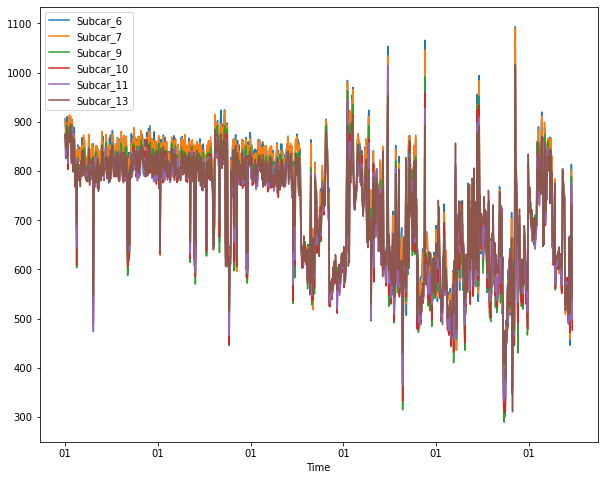

In [52]:
plot_cols = ['Subcar_6', 'Subcar_7','Subcar_9','Subcar_10', 'Subcar_11', 'Subcar_13']
plot_features = data_2[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=False)

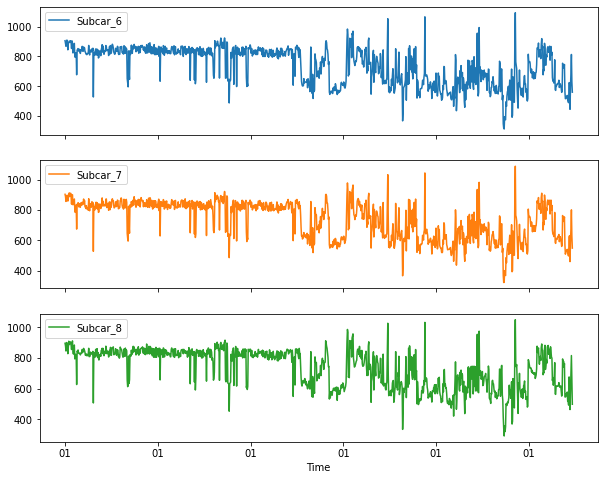

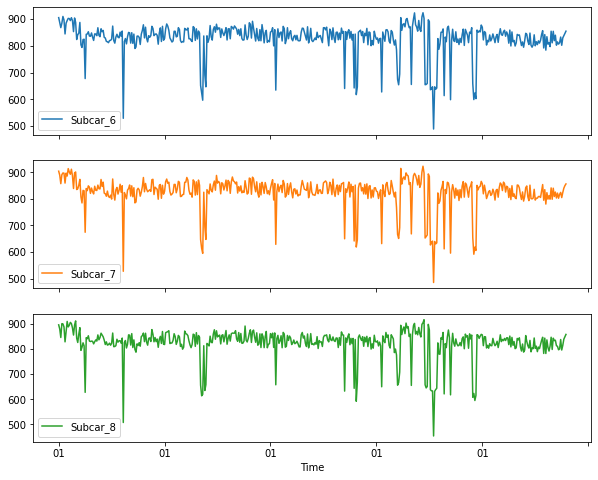

In [53]:
plot_cols = ['Subcar_6', 'Subcar_7', 'Subcar_8']
plot_features = data_2[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = data_2[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)

In [54]:
# Min-Max Normalization
scaler = MinMaxScaler()
scaler.fit(data_2.iloc[:, 0:100])
scaled_df = scaler.transform(data_2.iloc[:, 0:100])
data_2.iloc[:, 0:100] = scaled_df

In [82]:
# Split dataset
train_data, test_data = train_test_split(data_2, test_size=0.3)


print(train_data.shape)
print(test_data.shape)

(766, 64)
(329, 64)


In [83]:
train_feature = train_data.drop(columns=['Label'])
train_target = tf.keras.utils.to_categorical(train_data['Label'], num_classes=2)

test_feature = test_data.drop(columns=['Label'])
test_target = tf.keras.utils.to_categorical(test_data['Label'], num_classes=2)


print(train_feature.shape)
print(train_target.shape)

(766, 63)
(766, 2)


In [85]:
model = tf.keras.Sequential([tf.keras.layers.Dense(units=192, activation='relu', input_shape=(100,)),
                            tf.keras.layers.Dense(units=96, activation='relu'),
                            tf.keras.layers.Dense(units=48, activation='relu'),
                            tf.keras.layers.Dense(units=24, activation='relu'),
                            tf.keras.layers.Dense(units=12, activation='relu'),
                            tf.keras.layers.Dense(units=2, activation='sigmoid')])

model.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 192)               19392     
_________________________________________________________________
dense_17 (Dense)             (None, 96)                18528     
_________________________________________________________________
dense_18 (Dense)             (None, 48)                4656      
_________________________________________________________________
dense_19 (Dense)             (None, 24)                1176      
_________________________________________________________________
dense_20 (Dense)             (None, 12)                300       
_________________________________________________________________
dense_21 (Dense)             (None, 2)                 26        
Total params: 44,078
Trainable params: 44,078
Non-trainable params: 0
__________________________________________________

In [86]:
history = model.fit(
    train_feature, train_target, 
    epochs=50, batch_size=25, 
    validation_split=0.25, 
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=3, monitor='val_loss')])

print("\n Training is done! \n")


Epoch 1/50


ValueError: in user code:

    C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\tensorflow\python\keras\engine\training.py:806 train_function  *
        return step_function(self, iterator)
    C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\tensorflow\python\keras\engine\training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\tensorflow\python\distribute\distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\tensorflow\python\keras\engine\training.py:789 run_step  **
        outputs = model.train_step(data)
    C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\tensorflow\python\keras\engine\training.py:747 train_step
        y_pred = self(x, training=True)
    C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\tensorflow\python\keras\engine\base_layer.py:976 __call__
        self.name)
    C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\tensorflow\python\keras\engine\input_spec.py:216 assert_input_compatibility
        ' but received input with shape ' + str(shape))

    ValueError: Input 0 of layer sequential_2 is incompatible with the layer: expected axis -1 of input shape to have value 100 but received input with shape [None, 63]
